In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df = pd.read_csv('SolarPrediction.csv')
df

,UNIXTime,Data,Time,Radiation,Temperature,Pressure,Humidity,WindDirection(Degrees),Speed,TimeSunRise,TimeSunSet
0,1475229326,9/29/2016 12:00:00 AM,23:55:26,1.21,48,30.46,59,177.39,5.62,06:13:00,18:13:00
1,1475229023,9/29/2016 12:00:00 AM,23:50:23,1.21,48,30.46,58,176.78,3.37,06:13:00,18:13:00
2,1475228726,9/29/2016 12:00:00 AM,23:45:26,1.23,48,30.46,57,158.75,3.37,06:13:00,18:13:00
3,1475228421,9/29/2016 12:00:00 AM,23:40:21,1.21,48,30.46,60,137.71,3.37,06:13:00,18:13:00
4,1475228124,9/29/2016 12:00:00 AM,23:35:24,1.17,48,30.46,62,104.95,5.62,06:13:00,18:13:00
...,...,...,...,...,...,...,...,...,...,...,...
32681,1480587604,12/1/2016 12:00:00 AM,00:20:04,1.22,44,30.43,102,145.42,6.75,06:41:00,17:42:00
32682,1480587301,12/1/2016 12:00:00 AM,00:15:01,1.17,44,30.42,102,117.78,6.75,06:41:00,17:42:00
32683,1480587001,12/1/2016 12:00:00 AM,00:10:01,1.20,44,30.42,102,145.19,9.00,06:41:00,17:42:00
32684,1480586702,12/1/2016 12:00:00 AM,00:05:02,1.23,44,30.42,101,164.19,7.87,06:41:00,17:42:00


In [3]:
import data_prep

target_col = 'Radiation'  # Column to predict


X_train, X_val, X_test, y_train, y_val, y_test, scalers, feature_cols, transform_info = data_prep.prepare_weather_data(
        df,     
        target_col='Radiation',  
        window_size=24,
        feature_selection_mode='basic',  # Start with basic features
        standardize_features=False,  # Try StandardScaler
        use_solar_elevation=True,  # Try the solar elevation feature
        use_piecewise_transform=False,  # Start without piecewise transform
        log_transform=True, #figured out this one is super important
        #min_target_threshold=1.2
)

Adding solar elevation proxy feature
SolarElevation created for 32686 rows, 100.0% of data
Added 'Radiation_is_low' feature (threshold: 1.2000)
Added SolarElevation to features
Log-transformed Radiation -> Radiation_log
Using MinMaxScaler for feature scaling
X_train shape: (19596, 24, 17)
y_train shape: (19596, 1)
X_val shape: (6533, 24, 17)
y_val shape: (6533, 1)
X_test shape: (6533, 24, 17)
y_test shape: (6533, 1)
Features used: ['Radiation', 'Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'TimeMinutesSin', 'TimeMinutesCos', 'Radiation_is_low', 'SolarElevation', 'SunriseMinutes', 'SunsetMinutes', 'DaylightMinutes', 'TimeSinceSunrise', 'TimeUntilSunset', 'DaylightPosition', 'HourOfDay']


In [4]:
import gru 

model = gru.WeatherGRU(
    input_dim=X_train.shape[2],
    hidden_dim=64,
    num_layers=2,
    output_dim=1,
    dropout_prob=0.3
)


In [5]:
model.fit(         
        X_train, y_train, X_val, y_val, 
        epochs=100, 
        batch_size=32, 
        learning_rate=0.001,
        weight_decay=0.001,
        clip_grad_norm=1.0
        )

Epoch 10/100 | Train Loss: 0.0071 | Val Loss: 0.0072 | Train MAPE: 139.77% | Val MAPE: 184.00% | Val RMSE: 0.0848 | Val R²: 0.9478 | LR: 0.001000
Epoch 20/100 | Train Loss: 0.0067 | Val Loss: 0.0070 | Train MAPE: 134.65% | Val MAPE: 125.33% | Val RMSE: 0.0836 | Val R²: 0.9494 | LR: 0.000500
Early stopping at epoch 25


WeatherGRU(
  (gru): GRU(17, 64, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

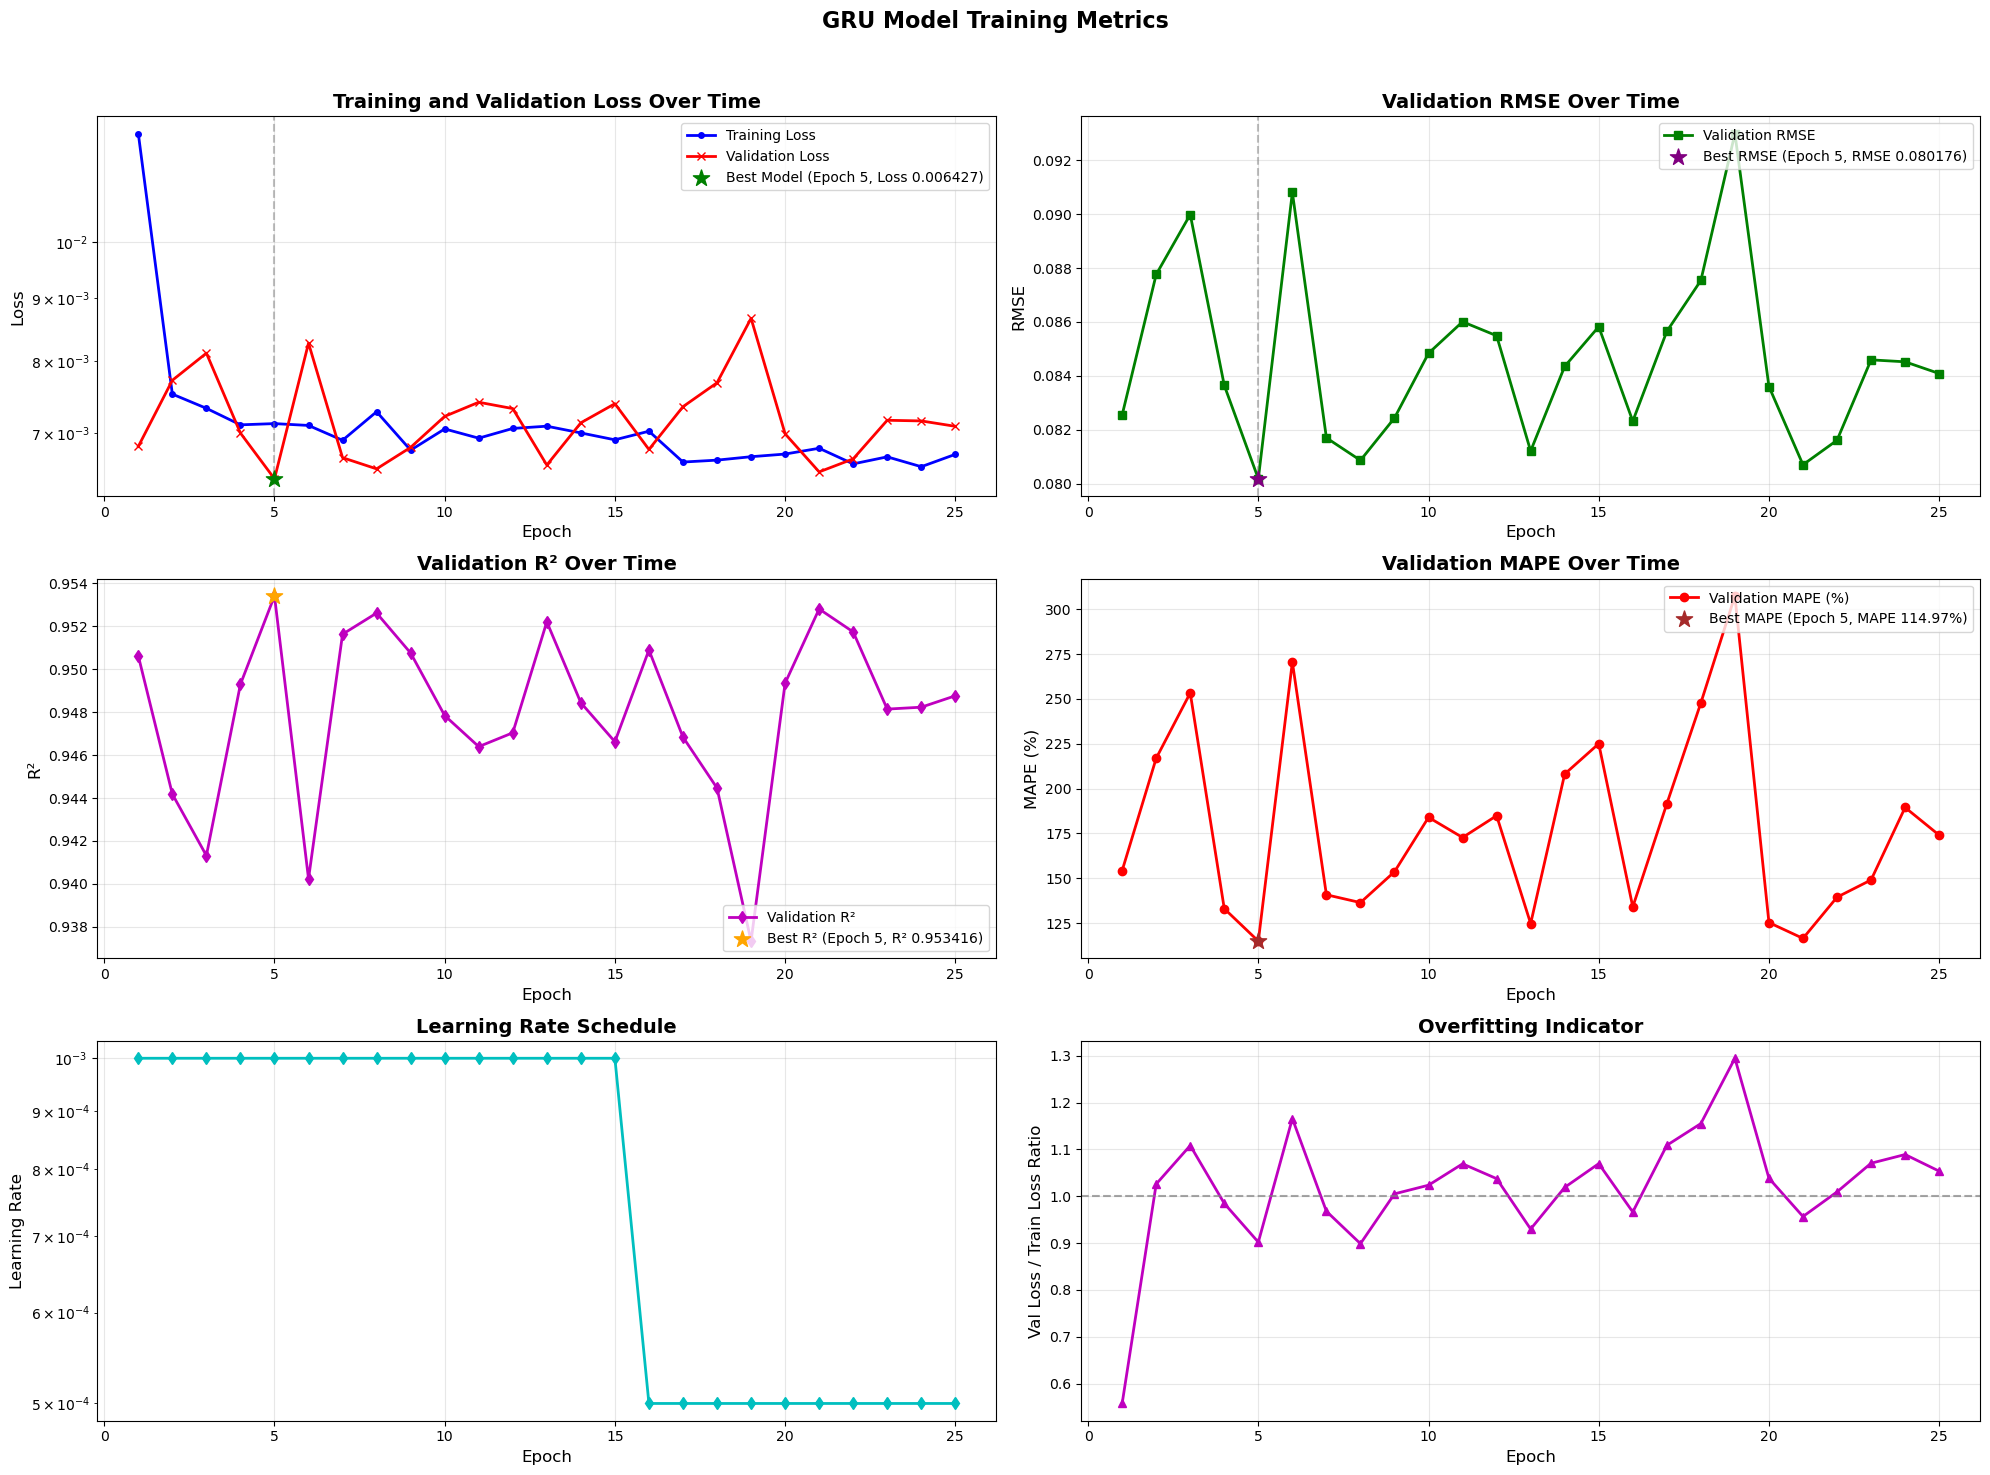

In [6]:
# Visualize training metrics
fig = model.plot_training_history()
plt.show()

In [15]:
metrics, predictions, actuals = model.evaluate(
    X_test, y_test,
    target_scaler=scalers["Radiation_log"],
    transform_info=transform_info
)

Evaluation Metrics:
MSE: 0.5358
RMSE: 0.7320
MAPE: 165.38%
R²: 0.9250


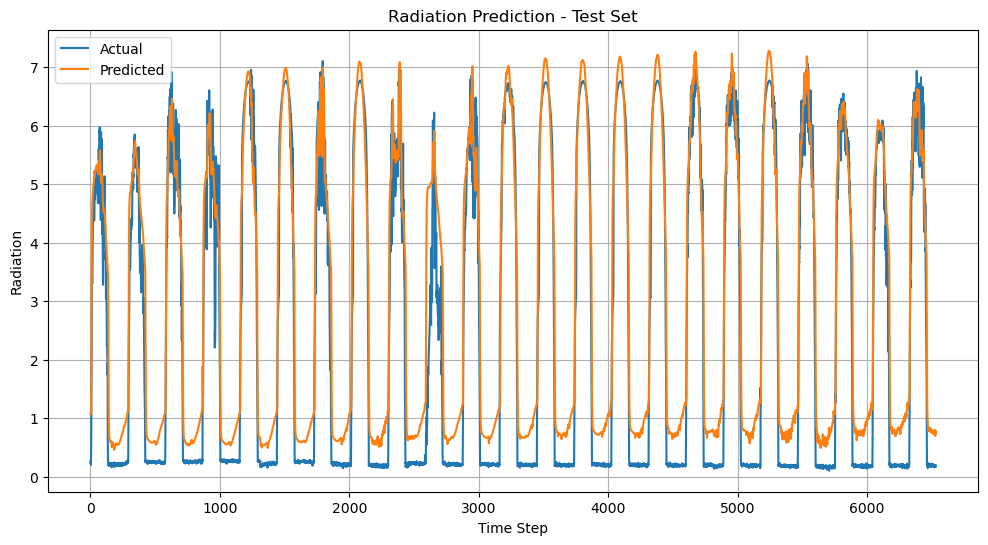

In [16]:
#plot predictions

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual')
plt.plot(predictions, label='Predicted')
plt.title('Radiation Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

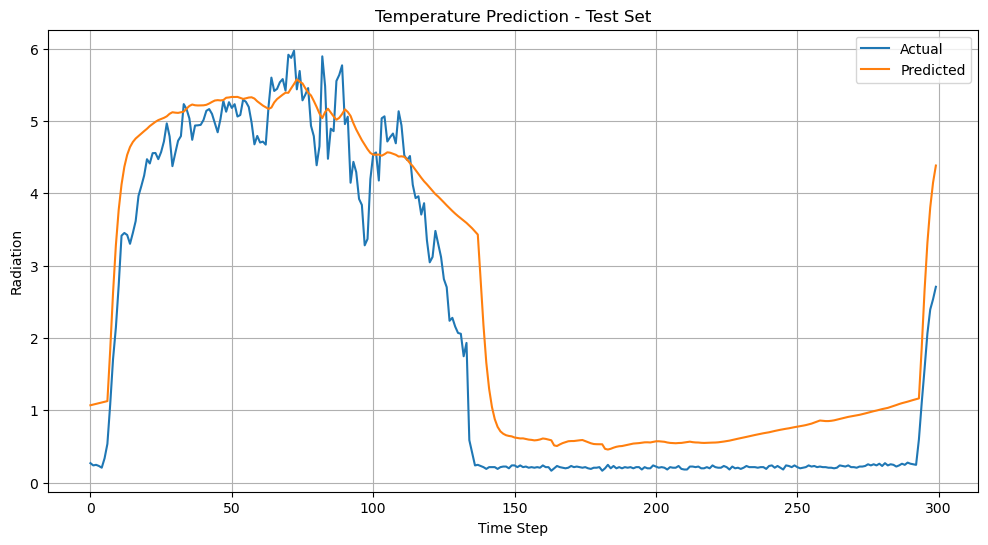

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(actuals[:300], label='Actual')
plt.plot(predictions[:300], label='Predicted')
plt.title('Temperature Prediction - Test Set')
plt.xlabel('Time Step')
plt.ylabel('Radiation')
plt.legend()
plt.grid(True)
plt.show()

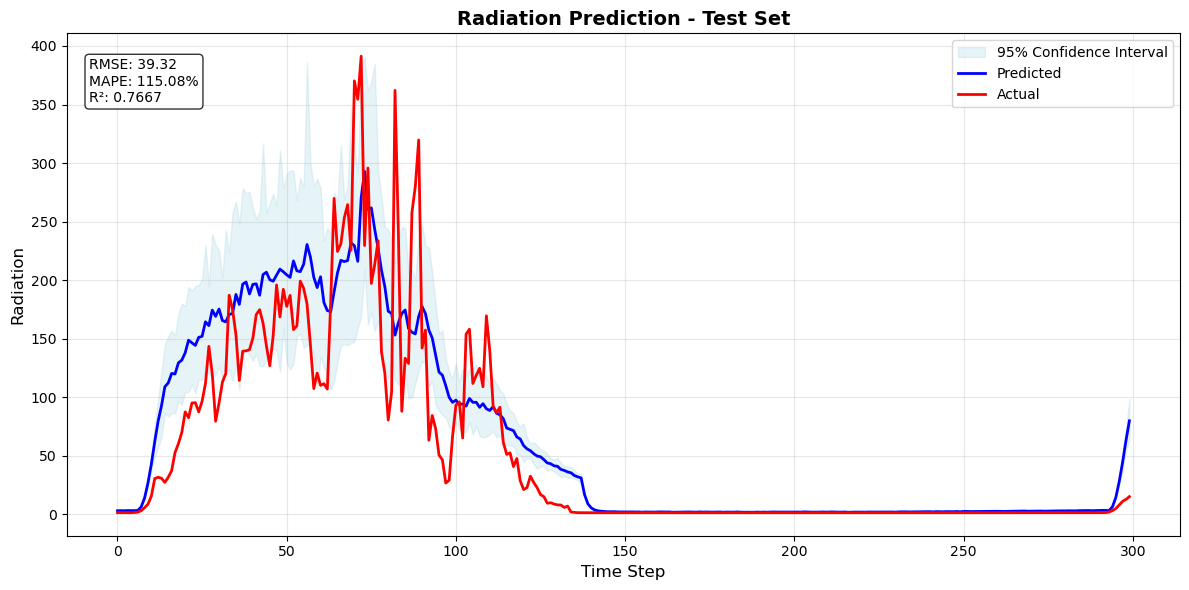

In [10]:
import gru
fig = model.plot_predictions(X_test[:300],
                             y_test[:300], 
                             mc_samples=30, 
                                       target_scaler=scalers["Radiation_log"], 
                                       transform_info=transform_info)
plt.show()

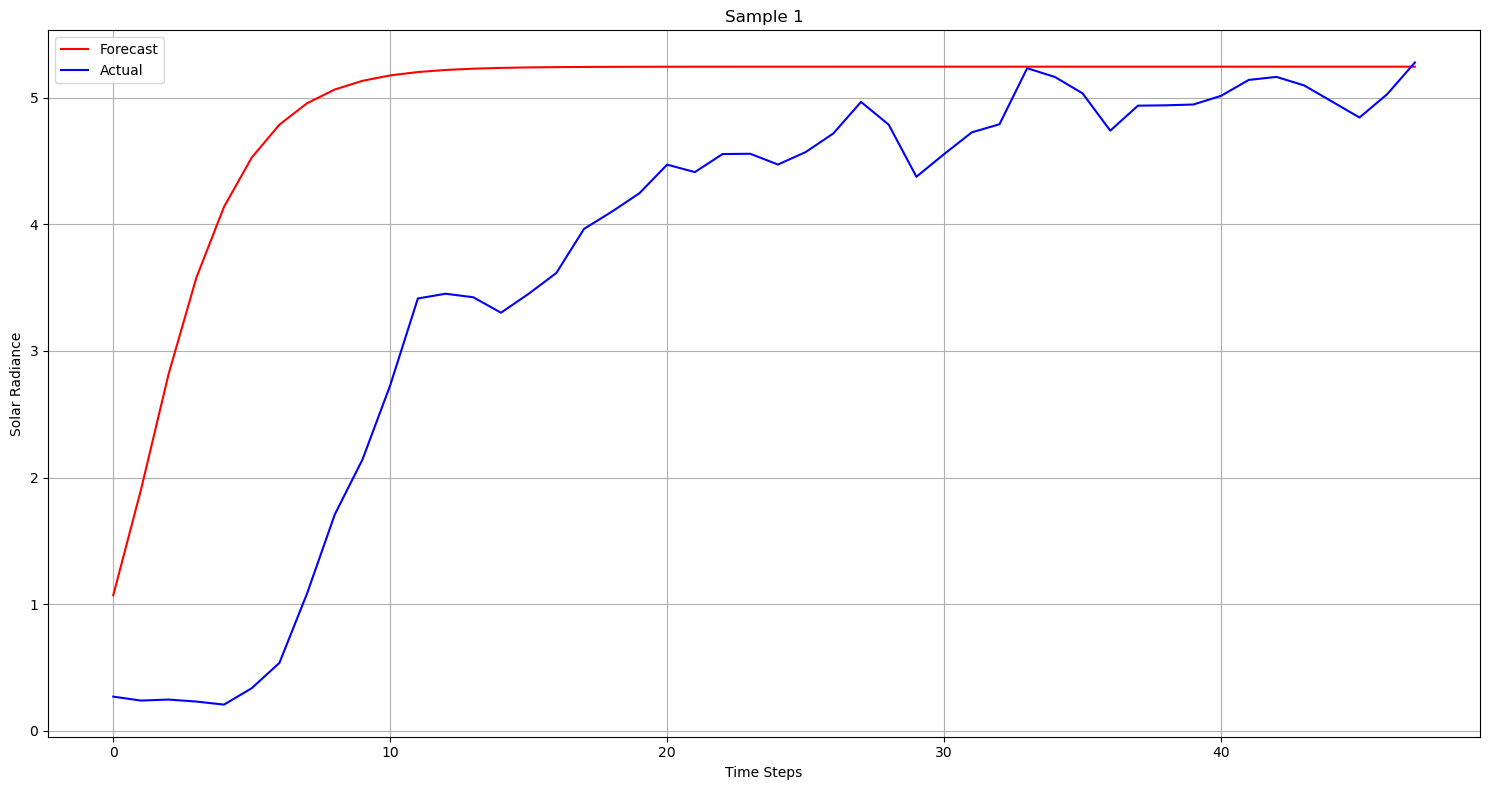

In [11]:
fig =model.plot_forecast(X_test, y_test, forecast_steps=48, target_scaler=scalers["Radiation_log"],
                     figsize=(15, 8), device="cpu", plot_samples=1, offset=0)
plt.show()

Resampling data to 1min frequency...
Original data points: 6533, After resampling: 6533
Evaluation Summary:
Number of samples (after resampling): 6533
RMSE: 0.731985
MAE: 0.578014
MAPE: 165.38%
R²: 0.924958
Correlation: 0.979470


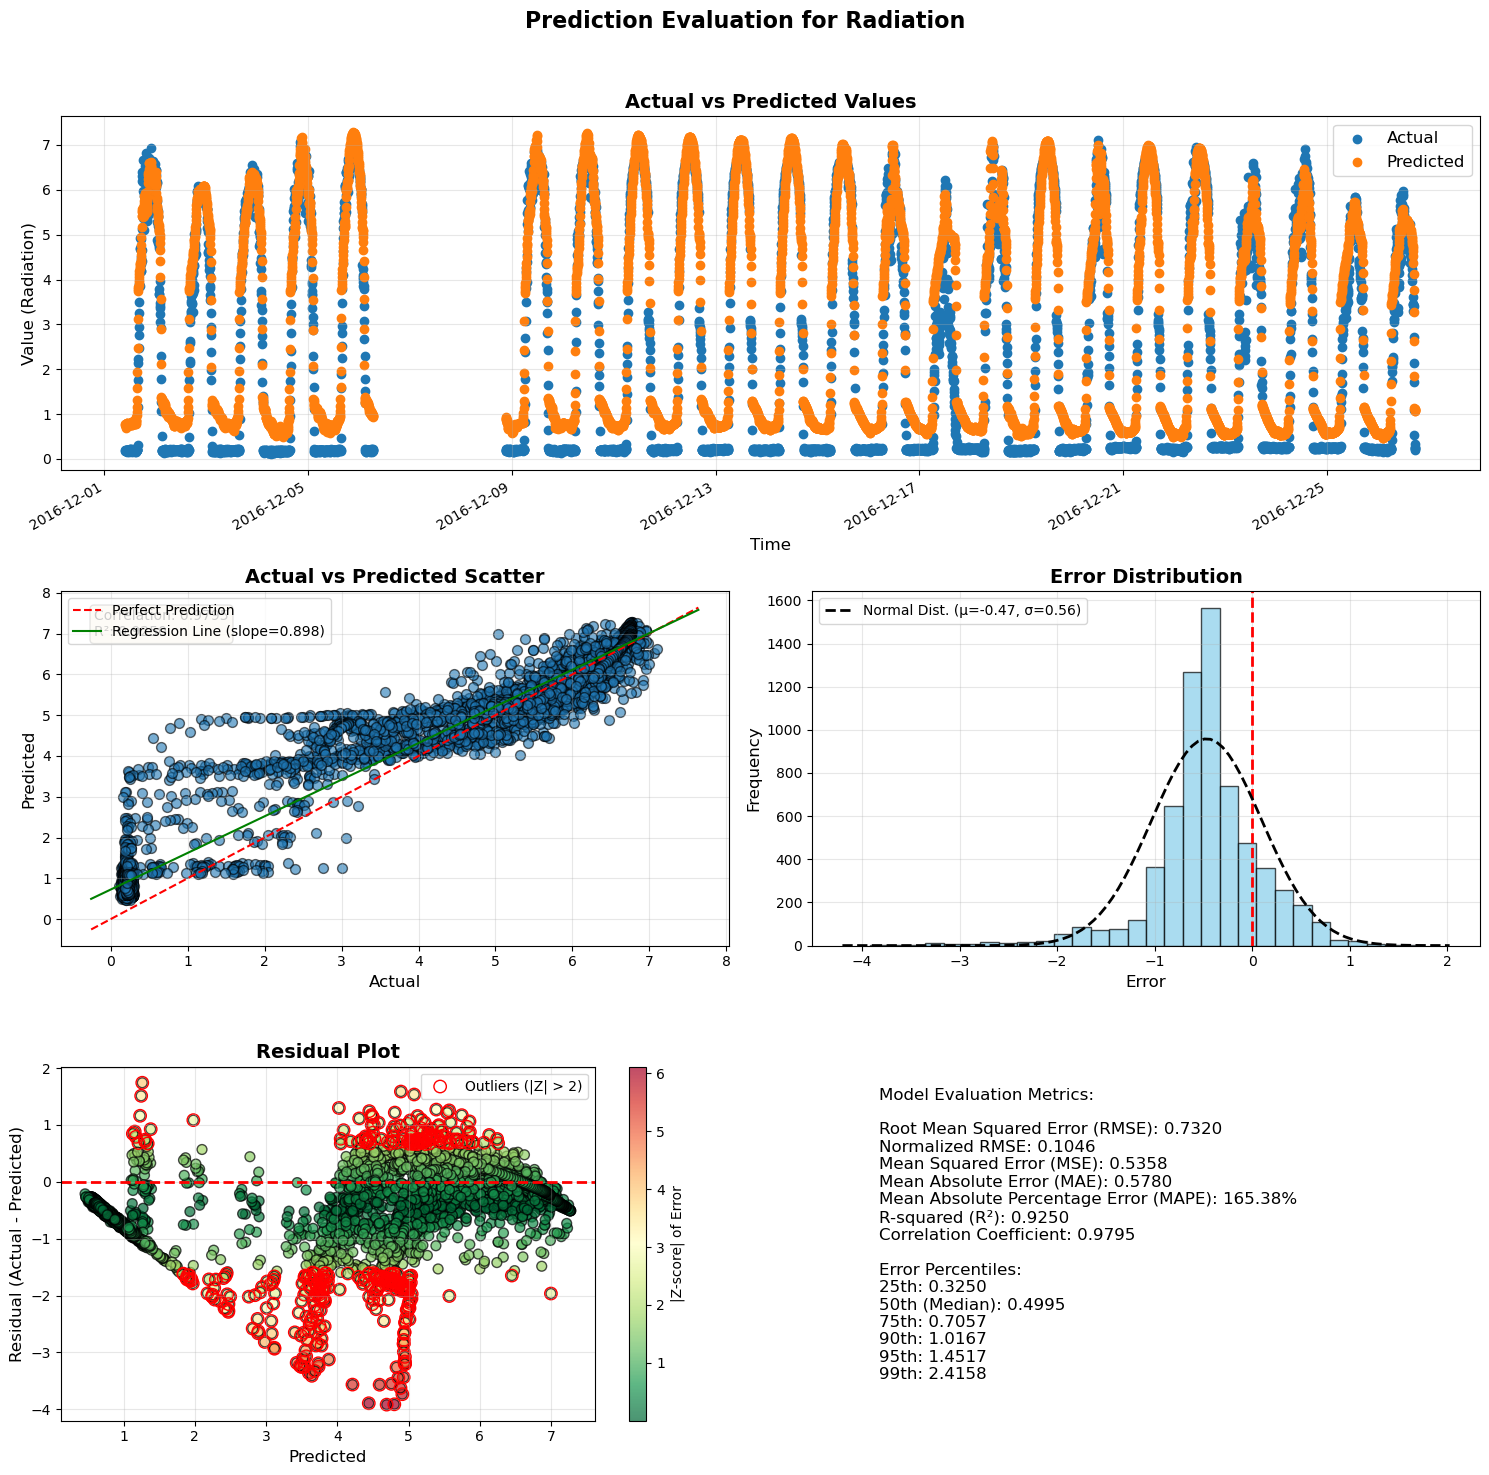

In [14]:
import plot_utils as pu 

# You can create timestamps if your data has a time component
timestamps = df['UNIXTime'].values[-len(predictions):]  # assuming UNIXTime exists in your df

# Make sure scaler is a dictionary with target_col as key
if not isinstance(scalers, dict):
    scalers_dict = {target_col: scalers}
else:
    scalers_dict = scalers

fig_eval = pu.create_evaluation_dashboard(
    predictions=predictions, 
    actuals=actuals, 
    scalers=None,  # !!! there is a bug here
    target_col=target_col,
    timestamps=timestamps
)

In [13]:
model.save('gru_model.pt')

Model saved to gru_model.pt
